# 0. Clean of classification_results_final.csv

In [20]:
import re
import pandas as pd

def clean_classification(classification):
    # Step 1: Convert to lowercase
    classification = classification.lower()
    
    # Step 2: Remove punctuation and extra whitespace
    classification = re.sub(r'[^\w\s]', '', classification)
    classification = re.sub(r'\s+', ' ', classification).strip()
    
    # Step 3: Apply corrections
    correction_map = {
        'neural': 'neutral',
        'neutral': 'neutral',
        'neither antiscience nor proscience neutral': 'neutral',
        'neither': 'neutral',
        'antivax': 'antiscience',
        'antivaccine': 'antiscience',
        # Add any other corrections here
    }
    
    return correction_map.get(classification, classification)

def apply_cleaning_pipeline(df, classification_column='final_classification'):
    # Apply the cleaning function to the specified column
    df['cleaned_classification'] = df[classification_column].astype(str).apply(clean_classification)
    
    # Compare the results
    print("Original classification counts:")
    print(df[classification_column].value_counts())
    print("\nInitial cleaned classification counts:")
    print(df['cleaned_classification'].value_counts())
    
    # Remove classifications with count <= 5
    classification_counts = df['cleaned_classification'].value_counts()
    rare_classifications = classification_counts[classification_counts <= 5].index
    df_filtered = df[~df['cleaned_classification'].isin(rare_classifications)]
    
    # Report on deleted entries
    deleted_entries = len(df) - len(df_filtered)
    print(f"\nNumber of entries deleted due to rare classifications: {deleted_entries}")
    
    print("\nFinal cleaned classification counts (after removing rare classifications):")
    print(df_filtered['cleaned_classification'].value_counts())
    
    # Identify changed classifications
    changed = df_filtered[df_filtered[classification_column] != df_filtered['cleaned_classification']]
    print(f"\nNumber of corrected classifications: {len(changed)}")
    
    print("\nExamples of corrected classifications:")
    for _, row in changed.head(10).iterrows():
        print(f"Original: {row[classification_column]} -> Cleaned: {row['cleaned_classification']}")
    
    # Check for any remaining unexpected classifications
    expected_classes = ['neutral', 'antiscience', 'proscience']
    unexpected = df_filtered[~df_filtered['cleaned_classification'].isin(expected_classes)]
    print(f"\nRemaining unexpected classifications: {len(unexpected)}")
    if len(unexpected) > 0:
        print("\nTop unexpected classifications:")
        print(unexpected['cleaned_classification'].value_counts().head(10))
    
    return df_filtered

# Usage example:
df = pd.read_csv(r'C:\Users\nrosso\Downloads\classification_results_final.csv')
df = apply_cleaning_pipeline(df)

Original classification counts:
final_classification
neutral                                                                                                                                           46901
antiscience                                                                                                                                       26593
proscience                                                                                                                                         5374
neutral.                                                                                                                                            765
antiscience.                                                                                                                                         75
                                                                                                                                                  ...  
i'm ready to classify a tweet based

# 0.1 Clean of the final data (to run with all the model)
- First merge and aggregate the results -> Chech the results here. 
- Clean aggregated classification -> clean the individual results and explore again how the final classification has changed 


## Merge and aggregate the results 

# 1. Class distribution

C:\Users\nrosso\AppData\Local\Temp\ipykernel_6844\3327361143.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\nrosso\AppData\Local\Temp\ipykernel_6844\3327361143.py:37: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



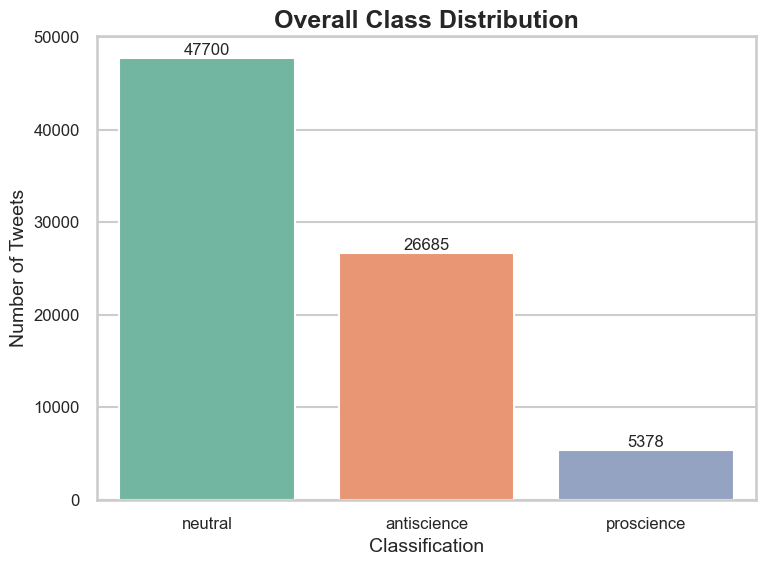

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_overall_class_distribution_static(df):
    class_counts = df['cleaned_classification'].value_counts().reset_index()
    class_counts.columns = ['Classification', 'Count']
    # Initialize the matplotlib figure
    sns.set(style="whitegrid")
    sns.set_context("talk")  # Adjusts font sizes
    plt.figure(figsize=(8, 6))
    

    # Create the bar plot
    sns.barplot(
        x='Classification',
        y='Count',
        data=class_counts,
        palette='Set2'
    )

    # Customize the plot
    plt.title('Overall Class Distribution', fontsize=18, fontweight='bold')
    plt.xlabel('Classification', fontsize=14)
    plt.ylabel('Number of Tweets', fontsize=14)

    # Adjust x and y ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on top of each bar
    ax = plt.gca()
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=12)

    # Remove legend (since it's not necessary for a single-category bar plot)
    plt.legend().set_visible(False)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Usage
# Assuming df is already defined and processed
plot_overall_class_distribution_static(df)

## Class Distribution - by model, to review (by merging and then cleaning the final data)

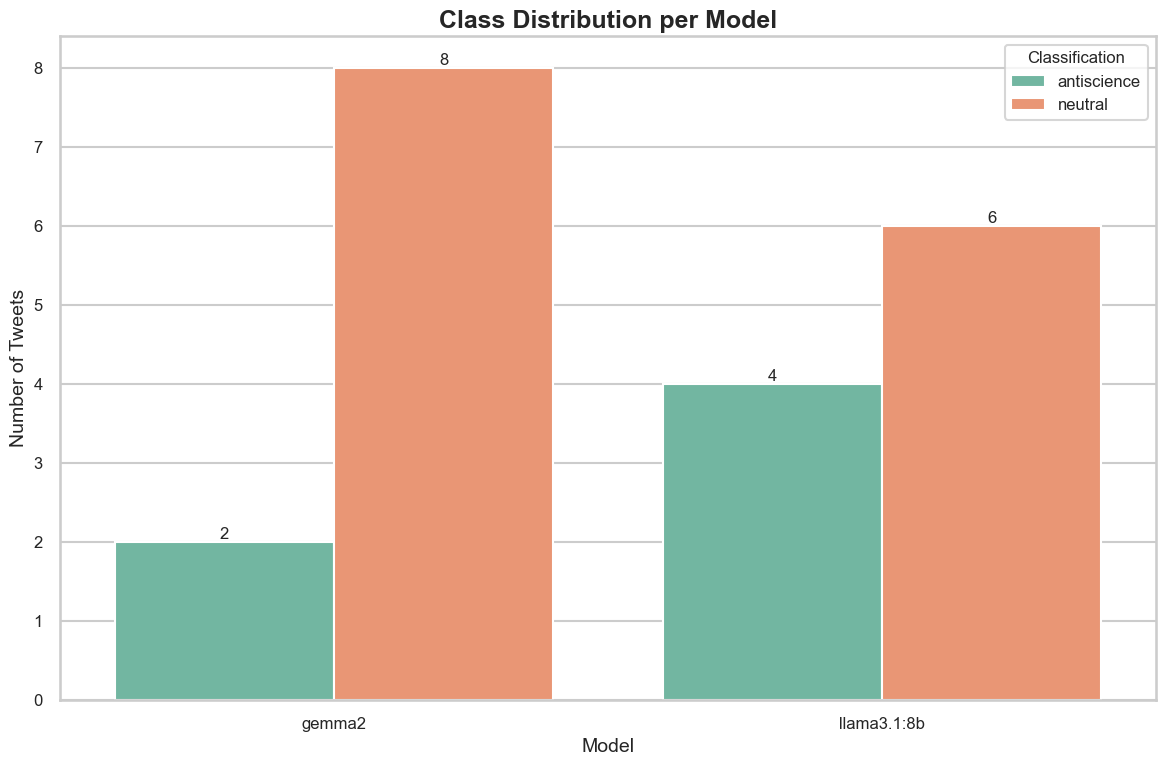

In [25]:
def create_long_format(df):
    records = []
    for idx, row in df.iterrows():
        tweet_index = row['index']
        individual_results = row['individual_results']
        for model, classification in individual_results.items():
            records.append({
                'Tweet Index': tweet_index,
                'Model': model,
                'Classification': classification
            })
    long_df = pd.DataFrame(records)
    return long_df

# Create the long-format DataFrame
long_df = create_long_format(df)
# Calculate counts of classifications per model
counts = long_df.groupby(['Model', 'Classification']).size().reset_index(name='Count')

import seaborn as sns
import matplotlib.pyplot as plt

def plot_class_distribution_by_model(counts):
    # Set the style
    sns.set(style="whitegrid")
    sns.set_context("talk")  # Adjusts font sizes

    # Initialize the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Create the bar plot
    sns.barplot(
        x='Model',
        y='Count',
        hue='Classification',
        data=counts,
        palette='Set2'
    )

    # Customize the plot
    plt.title('Class Distribution per Model', fontsize=18, fontweight='bold')
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Number of Tweets', fontsize=14)

    # Adjust legend
    plt.legend(title='Classification', title_fontsize=12, fontsize=12, loc='upper right')

    # Rotate x-axis labels if necessary
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on top of each bar
    ax = plt.gca()
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=12)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plot the class distribution by model
plot_class_distribution_by_model(counts)


# 2. Confidence distribution

c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




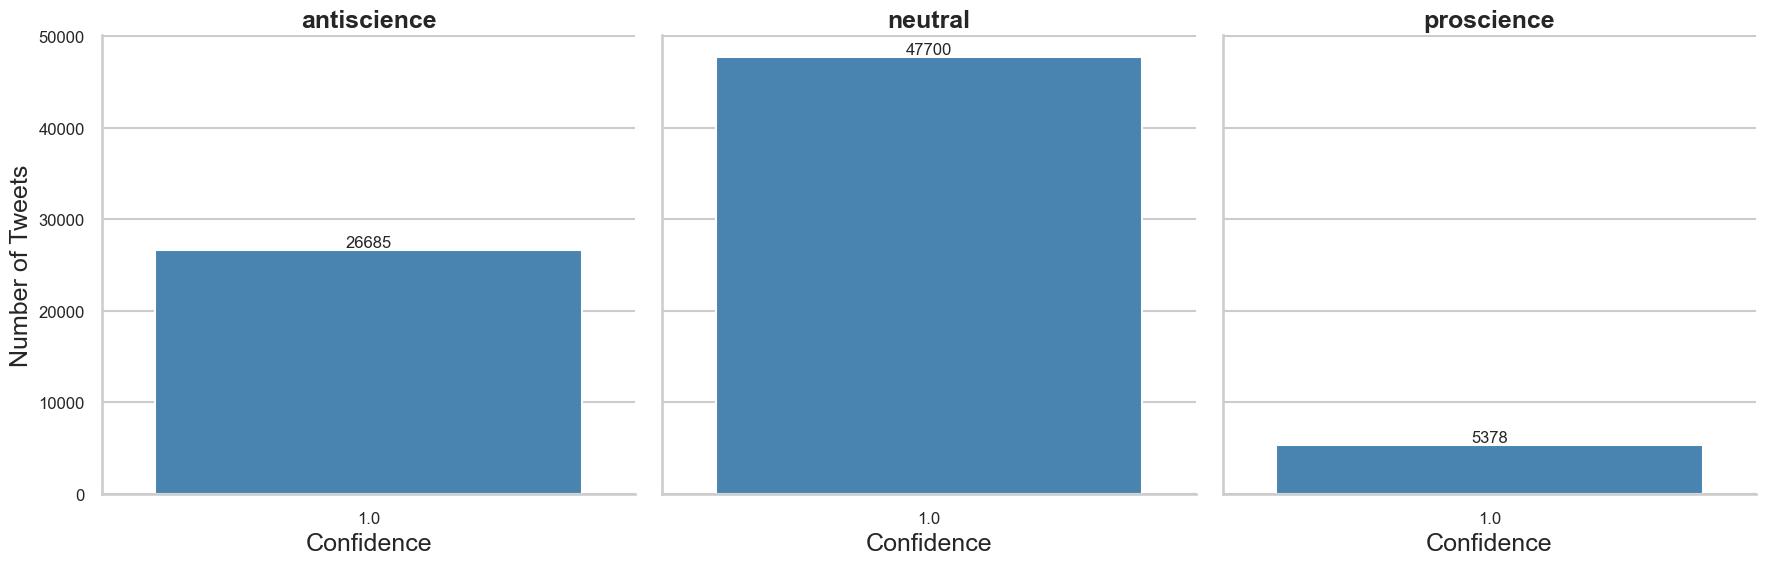

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_confidence_by_classification(df):
    # Ensure 'confidence' is numeric
    df['confidence'] = pd.to_numeric(df['confidence'], errors='coerce')
    
    # Round confidence values to handle floating-point precision issues
    df['confidence'] = df['confidence'].round(2)
    
    # Group by 'final_classification' and 'confidence' to get counts
    grouped = df.groupby(['cleaned_classification', 'confidence']).size().reset_index(name='Count')
    
    # Sort values for proper plotting
    grouped = grouped.sort_values(['cleaned_classification', 'confidence'])
    
    return grouped

def plot_confidence_distribution_by_classification(grouped_data):
    # Set the style and context
    sns.set(style="whitegrid")
    sns.set_context("talk")
    
    # Initialize the FacetGrid
    g = sns.FacetGrid(
        grouped_data,
        col="cleaned_classification",
        sharey=True,
        height=6,
        aspect=1
    )
    
    # Map the bar plot to each facet
    g.map_dataframe(
        sns.barplot,
        x='confidence',
        y='Count',
        palette='Blues_d',
        order=sorted(grouped_data['confidence'].unique())
    )
    
    # Add titles and labels
    g.set_axis_labels("Confidence", "Number of Tweets")
    g.set_titles("{col_name}", fontsize=16, fontweight='bold')
    
    # Adjust the tick labels
    for ax in g.axes.flat:
        ax.tick_params(labelsize=12)
        # Add data labels on top of each bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Usage
grouped_data = prepare_confidence_by_classification(df)
plot_confidence_distribution_by_classification(grouped_data)

# 2. Embeddings Space Analysis

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder

import plotly.express as px

def string_to_list(s):
    try:
        return literal_eval(s)
    except:
        print(f"Error processing string: {s[:100]}...")  # Print first 100 chars if there's an error
        return None

def load_and_preprocess_data(filepath):
    """
    Load the dataset and preprocess embeddings.
    """
    # Load your data
    df = pd.read_csv(filepath)
    
    # Convert 'dense_embedding' from string to list
    df['dense_embedding'] = df['dense_embedding'].apply(string_to_list)
    
    # Remove any rows where conversion failed (if any)
    df = df.dropna(subset=['dense_embedding'])
    
    # Extract embeddings into numpy array
    embeddings = np.array(df['dense_embedding'].tolist())
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    print(f"Loaded data shape: {df.shape}")
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Scaled embeddings shape: {embeddings_scaled.shape}")
    
    return df, embeddings_scaled

def reduce_dimensions_pca(embeddings_scaled, n_components=100):
    """
    Reduce embeddings to specified dimensions using PCA.
    """
    pca = PCA(n_components=n_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_scaled)
    return embeddings_pca

def reduce_dimensions_umap(embeddings_pca, n_components=3):
    """
    Reduce embeddings to specified dimensions using UMAP.
    """
    umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
    embeddings_umap = umap_reducer.fit_transform(embeddings_pca)
    return embeddings_umap

def reduce_dimensions_tsne(embeddings_pca, n_components=3):
    """
    Reduce embeddings to specified dimensions using t-SNE.
    """
    tsne = TSNE(n_components=n_components, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings_pca)
    return embeddings_tsne

def cluster_hdbscan(embeddings, min_cluster_size=5):
    """
    Cluster embeddings using HDBSCAN.
    """
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster_labels = clusterer.fit_predict(embeddings)
    return cluster_labels

def evaluate_clustering(df, cluster_labels, label_column):
    """
    Evaluate clustering performance using ARI and NMI.
    """
    # Exclude noise points
    valid_idx = cluster_labels != -1
    labels_true = df.loc[valid_idx, label_column]
    labels_pred = cluster_labels[valid_idx]
    
    ari = adjusted_rand_score(labels_true, labels_pred)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    
    return ari, nmi

def visualize_embeddings_3d(df, x_col, y_col, z_col, color_col, title):
    """
    Visualize 3D embeddings using Plotly Express.
    """
    fig = px.scatter_3d(
        df,
        x=x_col,
        y=y_col,
        z=z_col,
        color=color_col,
        labels={'color': color_col},
        title=title,
        template='plotly_white'
    )
    fig.show()

def main():
    # Step 1: Load and preprocess the data
    filepath = r'llama_cleaned_final_classification.csv'
    df, embeddings_scaled = load_and_preprocess_data(filepath)
    
    # Step 2: Reduce dimensions with PCA to 100 components
    embeddings_pca = reduce_dimensions_pca(embeddings_scaled, n_components=100)
    
    # Step 3: Dimensionality reduction with UMAP and t-SNE (now 3D)
    embeddings_umap = reduce_dimensions_umap(embeddings_pca, n_components=3)
    embeddings_tsne = reduce_dimensions_tsne(embeddings_pca, n_components=3)
    
    # Step 4: HDBSCAN clustering on UMAP and t-SNE embeddings
    cluster_labels_umap = cluster_hdbscan(embeddings_umap, min_cluster_size=5)
    cluster_labels_tsne = cluster_hdbscan(embeddings_tsne, min_cluster_size=5)
    
    # Step 5: Evaluate clustering performance
    # Add embeddings and cluster labels to dataframe
    df['UMAP1'] = embeddings_umap[:, 0]
    df['UMAP2'] = embeddings_umap[:, 1]
    df['UMAP3'] = embeddings_umap[:, 2]
    df['cluster_umap'] = cluster_labels_umap
    
    df['TSNE1'] = embeddings_tsne[:, 0]
    df['TSNE2'] = embeddings_tsne[:, 1]
    df['TSNE3'] = embeddings_tsne[:, 2]
    df['cluster_tsne'] = cluster_labels_tsne
    
    # Map final_classification to numeric labels
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['cleaned_classification'])
    
    # Evaluate clustering performance for UMAP embeddings
    ari_umap, nmi_umap = evaluate_clustering(df, cluster_labels_umap, 'label_encoded')
    print(f"UMAP + HDBSCAN - Adjusted Rand Index: {ari_umap:.4f}")
    print(f"UMAP + HDBSCAN - Normalized Mutual Information: {nmi_umap:.4f}")
    
    # Evaluate clustering performance for t-SNE embeddings
    ari_tsne, nmi_tsne = evaluate_clustering(df, cluster_labels_tsne, 'label_encoded')
    print(f"t-SNE + HDBSCAN - Adjusted Rand Index: {ari_tsne:.4f}")
    print(f"t-SNE + HDBSCAN - Normalized Mutual Information: {nmi_tsne:.4f}")
    
    # Step 6: Visualize the embeddings and clusters (now in 3D)
    # Visualize UMAP embeddings with clusters
    visualize_embeddings_3d(
        df,
        x_col='UMAP1',
        y_col='UMAP2',
        z_col='UMAP3',
        color_col='cluster_umap',
        title='3D UMAP Embeddings with HDBSCAN Clusters'
    )
    
    # Visualize UMAP embeddings with true labels
    visualize_embeddings_3d(
        df,
        x_col='UMAP1',
        y_col='UMAP2',
        z_col='UMAP3',
        color_col='cleaned_classification',
        title='3D UMAP Embeddings Colored by Final Classification'
    )
    
    # Visualize t-SNE embeddings with clusters
    visualize_embeddings_3d(
        df,
        x_col='TSNE1',
        y_col='TSNE2',
        z_col='TSNE3',
        color_col='cluster_tsne',
        title='3D t-SNE Embeddings with HDBSCAN Clusters'
    )
    
    # Visualize t-SNE embeddings with true labels
    visualize_embeddings_3d(
        df,
        x_col='TSNE1',
        y_col='TSNE2',
        z_col='TSNE3',
        color_col='cleaned_classification',
        title='3D t-SNE Embeddings Colored by Final Classification'
    )


main()

## 2.1 Embedding space + clustering

## 2.2 Embedding space + label propagation (??)

# 3. Model Disagreement Analysis

In [38]:
def extract_model_classifications(df):
    # Parse and clean 'individual_results'
    def parse_and_clean(row):
        # Check if 'individual_results' is a string
        if isinstance(row['individual_results'], str):
            results = literal_eval(row['individual_results'])
        elif isinstance(row['individual_results'], dict):
            results = row['individual_results']
        else:
            raise ValueError(f"Unsupported type for 'individual_results' in row {row.name}")
        
        # Clean the classification labels
        cleaned_results = {model: clean_label(label) for model, label in results.items()}
        return pd.Series(cleaned_results)
    
    # Apply the function to extract and clean model classifications
    model_classifications = df.apply(parse_and_clean, axis=1)
    model_classifications['index'] = df['index']
    return model_classifications
model_classifications = extract_model_classifications(df)

In [39]:
from collections import Counter

def calculate_disagreement_metrics(df, model_classifications):
    # Get the list of model columns
    model_columns = [col for col in model_classifications.columns if col != 'index']
    
    # Calculate the number of unique classifications per tweet
    model_classifications['num_unique_classifications'] = model_classifications[model_columns].nunique(axis=1)
    
    # Calculate the total number of models
    num_models = len(model_columns)
    model_classifications['num_models'] = num_models
    
    # Calculate the maximum agreement count (number of models agreeing on the majority class)
    def majority_agreement(row):
        classifications = row[model_columns].tolist()
        counter = Counter(classifications)
        most_common_classification, count = counter.most_common(1)[0]
        return count
    
    model_classifications['max_agreement_count'] = model_classifications.apply(majority_agreement, axis=1)
    
    # Calculate the number of disagreeing models
    model_classifications['num_disagreeing_models'] = model_classifications['num_models'] - model_classifications['max_agreement_count']
    
    # Merge back with the main DataFrame to include 'confidence' and 'final_classification'
    df_disagreement = pd.merge(df[['index', 'confidence', 'final_classification']], model_classifications, on='index')
    
    return df_disagreement, num_models

# Calculate disagreement metrics
df_disagreement, num_models = calculate_disagreement_metrics(df, model_classifications)

C:\Users\nrosso\AppData\Local\Temp\ipykernel_39712\3528109829.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




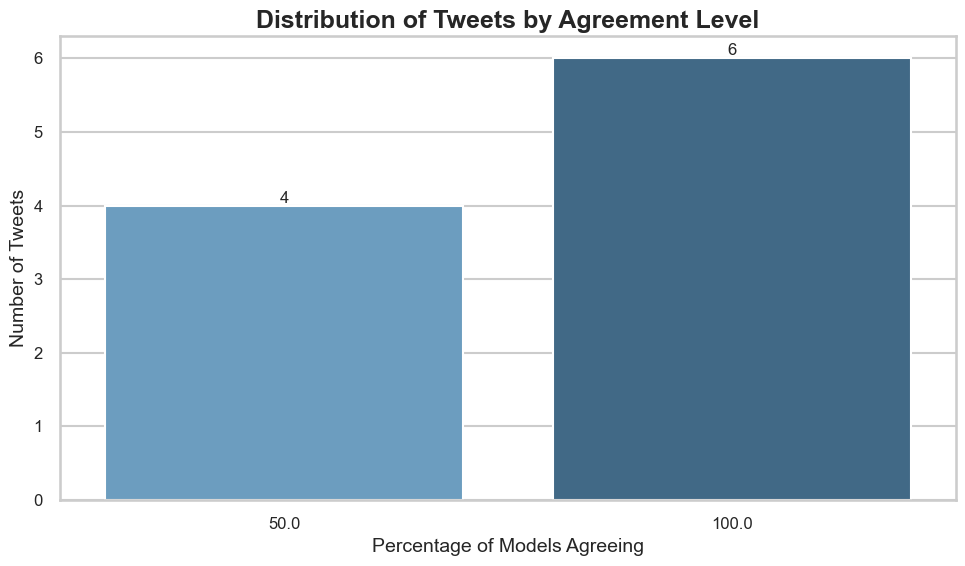

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_agreement_histogram(df_disagreement, num_models):
    # Calculate agreement percentage
    df_disagreement['agreement_percentage'] = (df_disagreement['max_agreement_count'] / num_models) * 100
    
    # Prepare data for plotting
    agreement_counts = df_disagreement['agreement_percentage'].value_counts().reset_index()
    agreement_counts.columns = ['Agreement Percentage', 'Count']
    agreement_counts = agreement_counts.sort_values('Agreement Percentage')
    
    # Set the style and context
    sns.set(style="whitegrid")
    sns.set_context("talk")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))
    
    # Create the bar plot
    sns.barplot(
        x='Agreement Percentage',
        y='Count',
        data=agreement_counts,
        palette='Blues_d'
    )
    
    # Customize the plot
    plt.title('Distribution of Tweets by Agreement Level', fontsize=18, fontweight='bold')
    plt.xlabel('Percentage of Models Agreeing', fontsize=14)
    plt.ylabel('Number of Tweets', fontsize=14)
    
    # Adjust x and y ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add data labels on top of each bar
    ax = plt.gca()
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=12)
    
    # Tight layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot the agreement histogram
plot_agreement_histogram(df_disagreement, num_models)

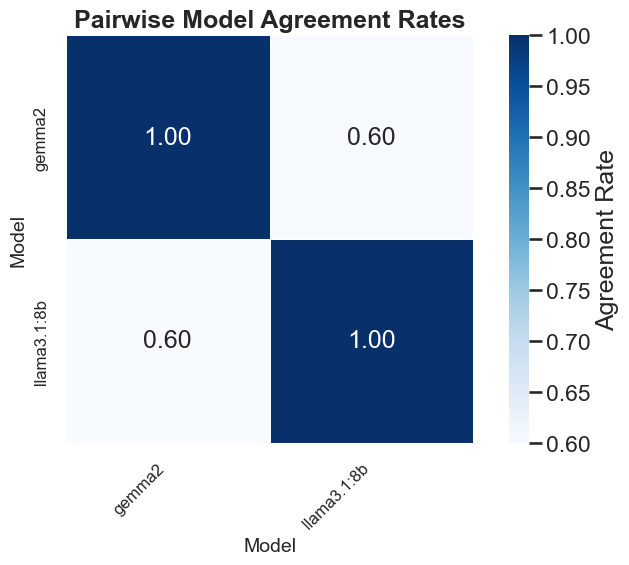

In [41]:
import itertools
import numpy as np

def compute_pairwise_agreements(model_classifications):
    model_columns = [col for col in model_classifications.columns if col not in ['index', 'num_unique_classifications', 'num_models', 'max_agreement_count', 'num_disagreeing_models']]
    pairwise_agreements = {}

    for model_a, model_b in itertools.combinations(model_columns, 2):
        agreements = (model_classifications[model_a] == model_classifications[model_b])
        agreement_rate = agreements.mean()
        pairwise_agreements[(model_a, model_b)] = agreement_rate

    return pairwise_agreements

def plot_pairwise_agreement_heatmap(pairwise_agreements):
    # Extract unique model names
    models = list(set([model for pair in pairwise_agreements.keys() for model in pair]))
    models.sort()
    
    # Create an agreement matrix
    agreement_matrix = pd.DataFrame(index=models, columns=models, data=np.nan)
    
    for (model_a, model_b), agreement_rate in pairwise_agreements.items():
        agreement_matrix.loc[model_a, model_b] = agreement_rate
        agreement_matrix.loc[model_b, model_a] = agreement_rate
    
    # Fill diagonal with 1.0 (perfect agreement with self)
    np.fill_diagonal(agreement_matrix.values, 1.0)
    
    # Set the style and context
    sns.set(style="white")
    sns.set_context("talk")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(8, 6))
    
    # Create the heatmap
    sns.heatmap(
        agreement_matrix.astype(float),
        annot=True,
        fmt=".2f",
        cmap='Blues',
        cbar_kws={'label': 'Agreement Rate'},
        linewidths=0.5,
        square=True
    )
    
    # Customize the plot
    plt.title('Pairwise Model Agreement Rates', fontsize=18, fontweight='bold')
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Model', fontsize=14)
    
    # Adjust tick labels
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    # Tight layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Compute pairwise agreements
pairwise_agreements = compute_pairwise_agreements(model_classifications)

# Plot the pairwise agreement heatmap
plot_pairwise_agreement_heatmap(pairwise_agreements)

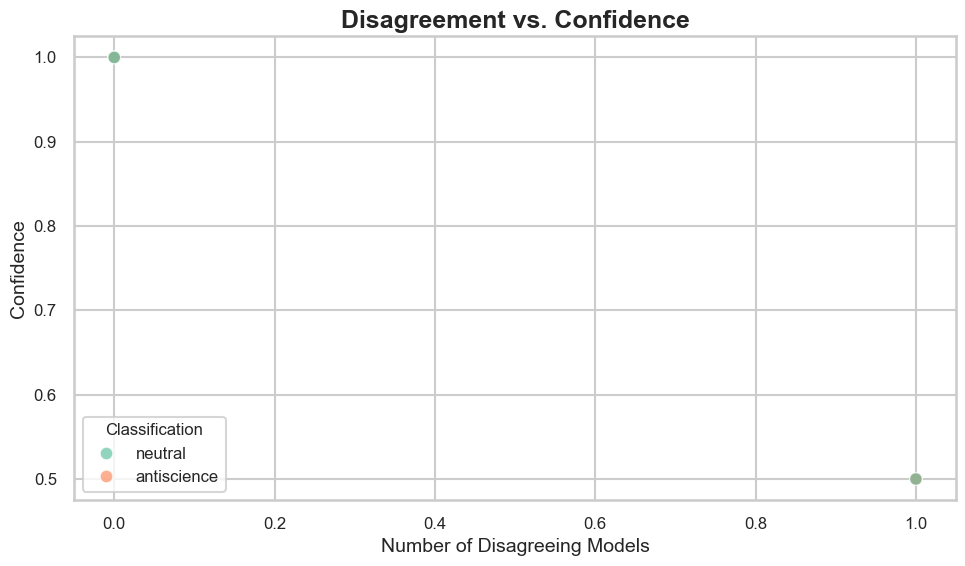

In [42]:
def plot_disagreement_vs_confidence(df_disagreement):
    # Ensure 'confidence' is numeric
    df_disagreement['confidence'] = pd.to_numeric(df_disagreement['confidence'], errors='coerce')
    
    # Set the style and context
    sns.set(style="whitegrid")
    sns.set_context("talk")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))
    
    # Create the scatter plot
    sns.scatterplot(
        data=df_disagreement,
        x='num_disagreeing_models',
        y='confidence',
        hue='final_classification',
        palette='Set2',
        alpha=0.7
    )
    
    # Customize the plot
    plt.title('Disagreement vs. Confidence', fontsize=18, fontweight='bold')
    plt.xlabel('Number of Disagreeing Models', fontsize=14)
    plt.ylabel('Confidence', fontsize=14)
    
    # Adjust legend
    plt.legend(title='Classification', title_fontsize=12, fontsize=12, loc='lower left')
    
    # Adjust tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Tight layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot disagreement vs. confidence
plot_disagreement_vs_confidence(df_disagreement)


## 3.1 Fleiss' Kappa
- a single measure to test the agreement between models

In [44]:
import pandas as pd
from ast import literal_eval
from sklearn.metrics import cohen_kappa_score
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa

# Read your data
df = pd.read_csv('../../classification_results_final.csv')

# Function to clean classification labels
def clean_label(label):
    return label.strip().lower().rstrip('.')

# Function to process the individual_results
def process_individual_results(row):
    # Parse the individual_results string into a dictionary
    classifications = literal_eval(row['individual_results'])
    # Clean the classification labels
    cleaned_classifications = {model: clean_label(label) for model, label in classifications.items()}
    return cleaned_classifications

# Apply the function to create a new column with cleaned individual results
df['cleaned_individual_results'] = df.apply(process_individual_results, axis=1)
# Get a list of all unique classifications
all_classifications = set()
for results in df['cleaned_individual_results']:
    all_classifications.update(results.values())
all_classifications = sorted(all_classifications)

# Map classifications to numeric codes
class_mapping = {label: idx for idx, label in enumerate(all_classifications)}

# Get a list of all models
all_models = set()
for results in df['cleaned_individual_results']:
    all_models.update(results.keys())
all_models = sorted(all_models)
# Function to create the matrix required for Fleiss' Kappa
def create_fleiss_kappa_matrix(df, class_mapping):
    num_classes = len(class_mapping)
    matrix = []

    for _, row in df.iterrows():
        classification_counts = [0] * num_classes
        individual_results = row['cleaned_individual_results']
        for model, classification in individual_results.items():
            class_idx = class_mapping[classification]
            classification_counts[class_idx] += 1
        matrix.append(classification_counts)
    
    return np.array(matrix)

# Create the matrix
fleiss_matrix = create_fleiss_kappa_matrix(df, class_mapping)
from statsmodels.stats.inter_rater import fleiss_kappa

# Calculate Fleiss' Kappa
kappa = fleiss_kappa(fleiss_matrix, method='fleiss')
print(f"Fleiss' Kappa: {kappa:.4f}")


Fleiss' Kappa: 0.0476


## 3.1 Fleiss' Kappa by Classes: are there any classes where the models struggle more to agree?

In [47]:
def calculate_class_wise_kappa(model_classifications, class_labels):
    class_kappa = {}
    for class_label in class_labels:
        # Filter instances of the class
        idx = model_classifications.apply(lambda row: class_label in row.values, axis=1)
        class_data = model_classifications[idx]

        # Calculate pairwise Kappa for this class
        class_cohen_kappa_matrix = pd.DataFrame(index=all_models, columns=all_models)
        for model_a, model_b in combinations(all_models, 2):
            valid_idx = class_data[[model_a, model_b]].dropna().index
            if len(valid_idx) == 0:
                kappa = np.nan
            else:
                kappa = cohen_kappa_score(
                    class_data.loc[valid_idx, model_a],
                    class_data.loc[valid_idx, model_b]
                )
            class_cohen_kappa_matrix.loc[model_a, model_b] = kappa
            class_cohen_kappa_matrix.loc[model_b, model_a] = kappa
        # Store the matrix
        class_kappa[class_label] = class_cohen_kappa_matrix.astype(float)
    return class_kappa

# Usage
class_kappa_matrices = calculate_class_wise_kappa(model_classifications, all_classifications)

# Example to visualize one class
for class_label, kappa_matrix in class_kappa_matrices.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(kappa_matrix, annot=True, fmt=".2f", cmap="YlOrBr")
    plt.title(f"Pairwise Cohen's Kappa for Class '{class_label}'")
    plt.show()

NameError: name 'combinations' is not defined

# 4. Uncertainty Quantification 

# 5. Cross Model Performance Analysis